# ATMS 597 Project 6 Group D

# Baseline models

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Commonly used modules
import numpy as np
import pandas as pd
import os
import sys

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn import preprocessing

# Images, plots, display, and visualization
import IPython
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale = 1.5)

# For storing logs
import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

print(tf.__version__)

2.0.0


In [2]:
# For reproducible results
from numpy.random import seed
seed(1)

In [106]:
# For inspecting neural net learning curves
def plot_history(unit, ymax):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [' + unit + ']')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,ymax])
    plt.show()

## Data Processing

<b> Set Working Directory </b>

In [4]:
#YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project6/' # Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Project6/' # Michael
YOUR_DIRECTORY = './' # David

<b> Import Data </b>

In [5]:
gfs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

<b> Merge Datasets </b>

In [6]:
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

<b> Other stuff </b>

In [7]:
# Add year, month, day as integers
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

<b> Split </b>

In [8]:
# Tmax
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Tmin 
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Wind
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Precip
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Random Forest

We use the optimized results from Group B in Project 4.

## Maximum Temperature

In [17]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

In [17]:
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


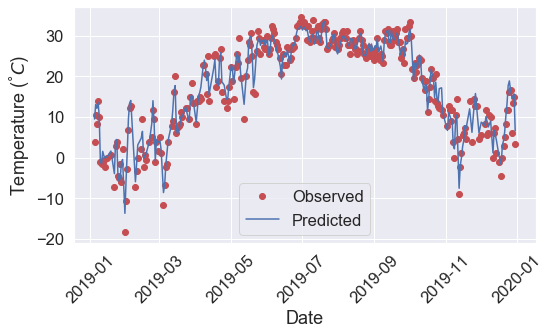

In [18]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

In [19]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

In [20]:
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


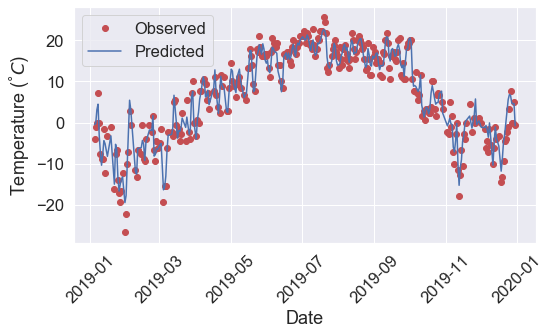

In [21]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Wind Speed

In [9]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

In [10]:
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


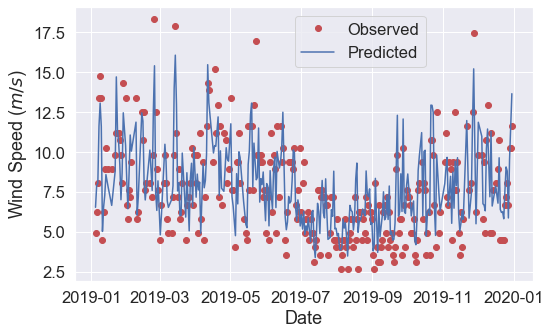

In [11]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Precipitation

In [25]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

In [26]:
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


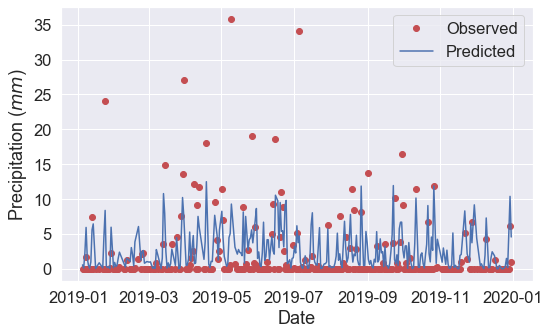

In [27]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Neural Network

We select the best baseline model with a minimum of three layers.

## Maximum Temperature

In [9]:
# Standardize
rf_train_vars_tmax_norm = preprocessing.scale(rf_train_vars_tmax)

### Build Model

In [49]:
# Build model with 3 hidden layers of 8 neurons each
def build_tmax_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

In [50]:
tmax_model = build_tmax_model()

In [51]:
tmax_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [52]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

history = tmax_model.fit(rf_train_vars_tmax_norm, train_verification_tmax, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 4s 2ms/sample - loss: 280.2446 - mae: 14.1078 - mse: 277.3450 - val_loss: 77.1619 - val_mae: 7.0360 - val_mse: 74.1700
Epoch 2/100
2631/2631 [==============================] - 0s 169us/sample - loss: 45.0895 - mae: 5.2692 - mse: 42.1021 - val_loss: 25.9949 - val_mae: 3.7462 - val_mse: 23.0367
Epoch 3/100
2631/2631 [==============================] - 0s 164us/sample - loss: 24.7216 - mae: 3.6705 - mse: 21.7836 - val_loss: 18.8653 - val_mae: 3.1234 - val_mse: 15.9391
Epoch 4/100
2631/2631 [==============================] - 0s 164us/sample - loss: 17.6496 - mae: 2.9752 - mse: 14.7457 - val_loss: 16.3228 - val_mae: 2.8691 - val_mse: 13.4333
Epoch 5/100
2631/2631 [==============================] - 0s 162us/sample - loss: 14.4661 - mae: 2.6264 - mse: 11.6040 - val_loss: 13.9220 - val_mae: 2.6192 - val_mse: 11.0878
Epoch 6/100
2631/2631 [==============================] - 1s 249us/sample - lo

### RMSE

In [53]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.05


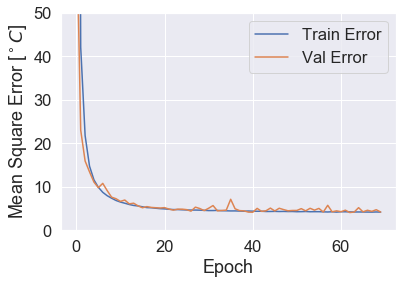

In [54]:
plot_history('$^\circ C$', 50)

In [55]:
rf_test_vars_tmax_norm = preprocessing.scale(rf_test_vars_tmax)
tmax_rmse = mean_squared_error(test_verification_tmax, tmax_model.predict(rf_test_vars_tmax_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(tmax_rmse, 3)))

Root Mean Square Error on test set: 1.969


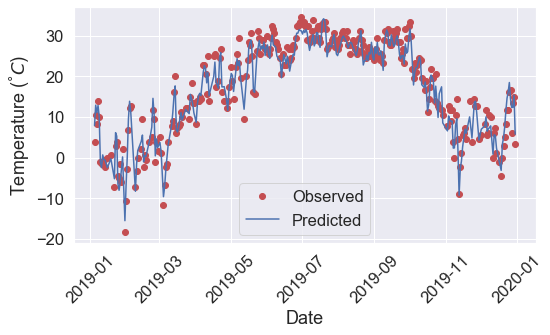

In [41]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, tmax_model.predict(rf_test_vars_tmax_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

In [56]:
# Standardize
rf_train_vars_tmin_norm = preprocessing.scale(rf_train_vars_tmin)

In [73]:
def build_tmin_model():
    model = keras.Sequential([
        Dense(12, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(12, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(12, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [74]:
tmin_model = build_tmin_model()

In [75]:
tmin_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 12)                336       
_________________________________________________________________
dense_29 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_30 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 13        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [76]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

history = tmin_model.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=300, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/300
2631/2631 [==============================] - 12s 5ms/sample - loss: 117.8587 - mae: 8.9407 - mse: 116.0686 - val_loss: 85.5450 - val_mae: 7.6067 - val_mse: 83.7006
Epoch 2/300
2631/2631 [==============================] - 1s 427us/sample - loss: 36.7082 - mae: 4.7124 - mse: 34.8123 - val_loss: 14.9111 - val_mae: 2.8006 - val_mse: 12.9829
Epoch 3/300
2631/2631 [==============================] - 1s 447us/sample - loss: 12.9258 - mae: 2.6376 - mse: 11.0204 - val_loss: 11.7257 - val_mae: 2.4319 - val_mse: 9.8388
Epoch 4/300
2631/2631 [==============================] - 1s 441us/sample - loss: 10.0019 - mae: 2.2615 - mse: 8.1356 - val_loss: 9.2615 - val_mae: 2.0192 - val_mse: 7.4150
Epoch 5/300
2631/2631 [==============================] - 1s 441us/sample - loss: 8.4564 - mae: 2.0221 - mse: 6.6218 - val_loss: 7.9786 - val_mae: 1.8486 - val_mse: 6.1568
Epoch 6/300
2631/2631 [==============================] - 1s 352us/sample - loss: 7.65

In [77]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.098


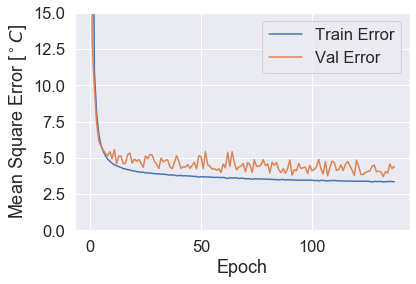

In [78]:
plot_history('$^\circ C$', 15)

In [79]:
rf_test_vars_tmin_norm = preprocessing.scale(rf_test_vars_tmin)
tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model.predict(rf_test_vars_tmin_norm), squared=False)
print('RMSE on test set: {}'.format(round(tmin_rmse, 3)))

RMSE on test set: 2.116


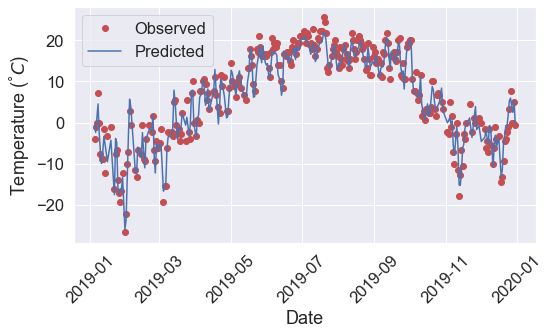

In [81]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, tmin_model.predict(rf_test_vars_tmin_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Wind Speed

In [82]:
# Standardize
rf_train_vars_wind_norm = preprocessing.scale(rf_train_vars_wind)

### Model

In [83]:
# Build model
def build_wind_model():
    model = keras.Sequential([
        Dense(4, activation=tf.nn.relu, input_shape=[len(rf_train_vars_wind_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(4, activation=tf.nn.relu, input_shape=[len(rf_train_vars_wind_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(4, activation=tf.nn.relu, input_shape=[len(rf_train_vars_wind_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(1, activation=tf.nn.relu)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [84]:
wind_model = build_wind_model()

In [85]:
wind_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 4)                 360       
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


In [86]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

history = wind_model.fit(rf_train_vars_wind_norm, train_verification_wind, epochs=300, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/300
2631/2631 [==============================] - 10s 4ms/sample - loss: 58.2131 - mae: 6.8936 - mse: 57.4339 - val_loss: 42.9136 - val_mae: 5.4263 - val_mse: 42.1157
Epoch 2/300
2631/2631 [==============================] - 1s 347us/sample - loss: 34.5215 - mae: 4.8188 - mse: 33.7013 - val_loss: 23.3777 - val_mae: 3.7642 - val_mse: 22.5389
Epoch 3/300
2631/2631 [==============================] - 1s 455us/sample - loss: 14.7377 - mae: 2.9735 - mse: 13.8776 - val_loss: 9.8052 - val_mae: 2.2819 - val_mse: 8.9279
Epoch 4/300
2631/2631 [==============================] - 1s 372us/sample - loss: 8.3318 - mae: 2.1817 - mse: 7.4638 - val_loss: 7.8733 - val_mae: 2.0291 - val_mse: 7.0179
Epoch 5/300
2631/2631 [==============================] - 1s 346us/sample - loss: 6.8968 - mae: 1.9580 - mse: 6.0538 - val_loss: 7.1120 - val_mae: 1.9203 - val_mse: 6.2830
Epoch 6/300
2631/2631 [==============================] - 1s 449us/sample - loss: 6.0092 -

### RMSE

In [87]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 1.589


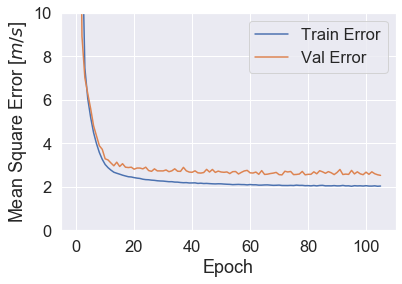

In [88]:
plot_history('$m/s$', 10)

In [89]:
rf_test_vars_wind_norm = preprocessing.scale(rf_test_vars_wind)
wind_rmse = mean_squared_error(test_verification_wind, wind_model.predict(rf_test_vars_wind_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(wind_rmse, 3)))

Root Mean Square Error on test set: 1.715


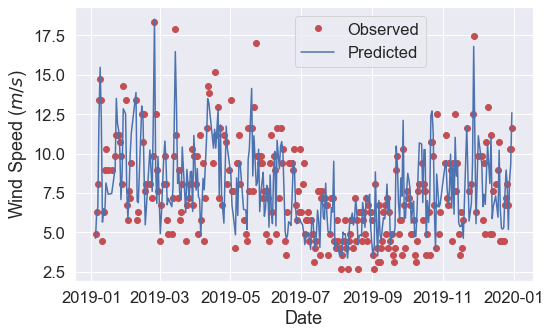

In [91]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, wind_model.predict(rf_test_vars_wind_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Total Precipitation

In [92]:
# Standardize
rf_train_vars_prcp_norm = preprocessing.scale(rf_train_vars_prcp)

### Model

In [116]:
# Build model. Here we add 1 additional dropout layer to prevent overfitting
def build_prcp_model():
    model = keras.Sequential([
        Dense(5, activation=tf.nn.relu, input_shape=[len(rf_train_vars_prcp_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.3),
        Dense(5, activation=tf.nn.relu, input_shape=[len(rf_train_vars_prcp_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(5, activation=tf.nn.relu, input_shape=[len(rf_train_vars_prcp_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(1, activation=tf.nn.relu)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

In [117]:
prcp_model = build_prcp_model()

In [118]:
prcp_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 5)                 130       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 6         
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [119]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

history = prcp_model.fit(rf_train_vars_prcp_norm, train_verification_prcp, epochs=200, validation_split = 0.1, callbacks=[early_stop,tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/200
2631/2631 [==============================] - 11s 4ms/sample - loss: 37.7615 - mae: 2.2359 - mse: 37.1020 - val_loss: 54.9207 - val_mae: 2.8213 - val_mse: 54.2713
Epoch 2/200
2631/2631 [==============================] - 1s 358us/sample - loss: 35.8090 - mae: 2.4115 - mse: 35.1655 - val_loss: 52.3089 - val_mae: 2.9756 - val_mse: 51.6713
Epoch 3/200
2631/2631 [==============================] - 1s 371us/sample - loss: 34.0683 - mae: 2.5696 - mse: 33.4340 - val_loss: 50.1922 - val_mae: 3.0992 - val_mse: 49.5621
Epoch 4/200
2631/2631 [==============================] - 1s 407us/sample - loss: 32.2028 - mae: 2.6355 - mse: 31.5751 - val_loss: 48.5650 - val_mae: 3.2203 - val_mse: 47.9373
Epoch 5/200
2631/2631 [==============================] - 1s 396us/sample - loss: 31.7964 - mae: 2.7342 - mse: 31.1737 - val_loss: 47.9057 - val_mae: 3.2060 - val_mse: 47.2896
Epoch 6/200
2631/2631 [==============================] - 1s 382us/sample - loss

### RMSE

In [120]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 6.781


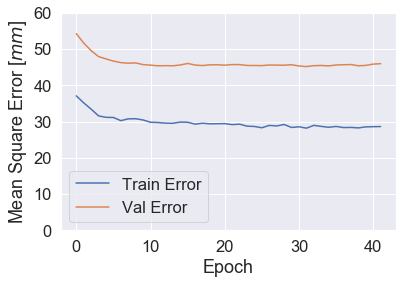

In [121]:
plot_history('$mm$', 60)

In [122]:
rf_test_vars_prcp_norm = preprocessing.scale(rf_test_vars_prcp)
prcp_rmse = mean_squared_error(test_verification_prcp, prcp_model.predict(rf_test_vars_prcp_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(prcp_rmse, 3)))

Root Mean Square Error on test set: 4.169


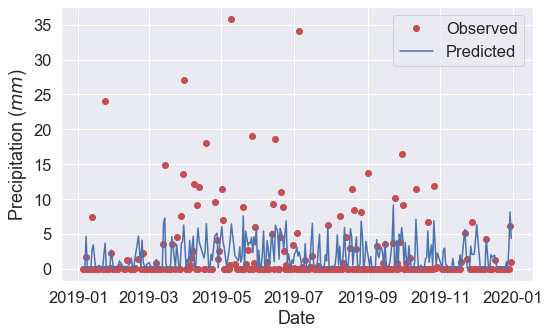

In [124]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, prcp_model.predict(rf_test_vars_prcp_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()